# Figure S2: Total Precipitations bias
conda env: new `phd_v3`, old `work` (in `envs/phd`)

In [1]:
# To reload external files automatically (ex: utils)
%load_ext autoreload
%autoreload 2

import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import proplot as plot # New plot library (https://proplot.readthedocs.io/en/latest/)
plot.rc['savefig.dpi'] = 300 # 1200 is too big! #https://proplot.readthedocs.io/en/latest/basics.html#Creating-figures
from scipy import stats
import xesmf as xe # For regridding (https://xesmf.readthedocs.io/en/latest/)

import sys
sys.path.insert(1, '/home/mlalande/notebooks/utils') # to include my util file in previous directory
import utils as u # my personal functions
u.check_python_version()
# u.check_virtual_memory()

3.8.5 | packaged by conda-forge | (default, Jul 24 2020, 01:25:15) 
[GCC 7.5.0]


## Set variables

In [2]:
period = slice('1979','2014')
latlim, lonlim = u.get_domain_HMA()
seasons = ['Annual', 'DJFMA', 'JJAS']
# seasons = ['Annual']

# Make a extended version for regridding properly on the edges
latlim_ext, lonlim_ext = slice(latlim.start-5, latlim.stop+5), slice(lonlim.start-5, lonlim.stop+5)

# Get zone limits for annual cycle
lonlim_HK, latlim_HK, lonlim_HM, latlim_HM, lonlim_TP, latlim_TP = u.get_zones()

# HMA for full domain and the following for the above zones
zones = ['HMA', 'HK', 'HM', 'TP']
zones_df = pd.DataFrame(
    [[lonlim, latlim], [lonlim_HK, latlim_HK], [lonlim_HM, latlim_HM], [lonlim_TP, latlim_TP]], 
    columns=pd.Index(['lonlim', 'latlim'], name='Limits'),
    index=pd.Index(zones, name='Zones')
)

var = 'pr'
table = u.get_table(var)
label, units, levels, cmap, extend, \
    levels_diff, cmap_diff, extend_diff, \
    levels_bias, cmap_bias, extend_bias = u.get_var_infos(var)
label

'Total Precipitation'

## Load topography

In [3]:
ds = xr.open_dataset('GMTED2010_15n240_1000deg.nc').drop_dims('nbounds').swap_dims(
    {'nlat': 'latitude', 'nlon': 'longitude'}).drop({'nlat', 'nlon'}).rename(
    {'latitude': 'lat', 'longitude': 'lon'}).sel(lat=latlim_ext, lon=lonlim_ext)
elevation = ds.elevation
elevation_std = ds.elevation_stddev

## Load obs
APHRODITE V1101 et V1101EX_R1 domain MA: http://aphrodite.st.hirosaki-u.ac.jp/download/data/search/, http://aphrodite.st.hirosaki-u.ac.jp/download/


In [4]:
obs_longname = 'APHRODITE V1101 (0.5°)'
obs_name = 'APHRODITE'

obs_V1101 = xr.open_mfdataset(
    '/data/mlalande/APHRODITE/APHRO_MA_050deg_V1101.*.nc', combine='by_coords'
).precip
obs_V1101_EXR1 = xr.open_mfdataset(
    '/data/mlalande/APHRODITE/APHRO_MA_050deg_V1101_EXR1.*.nc', combine='by_coords'
).precip

obs_V1101 = obs_V1101.rename({'longitude': 'lon', 'latitude': 'lat'})
obs = (xr.combine_nested([obs_V1101, obs_V1101_EXR1], concat_dim='time')).sel(time=period)

# Resamble data per month (from per day)
obs = obs.resample(time='1MS').mean('time', skipna=False, keep_attrs=True)

# Check if the time steps are ok
np.testing.assert_equal((int(period.stop) - int(period.start) + 1)*12, obs.time.size)

temp = []
for season in seasons:
    temp.append(
        u.clim(obs, calendar='standard', season=season)
    )

# Compute climatology and annual cycle
obs_clim = xr.combine_nested(temp, concat_dim='season')

/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/common.py:1123: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  grouper = pd.Grouper(


In [5]:
# obs_clim[2].plot()
# obs_ac
# u.spatial_average(obs_ac).plot()

## Regrid obs towards the elevation grid of 1°x1°
Using xESMF (https://xesmf.readthedocs.io/en/latest/)

In [6]:
# Because obs are not global (https://github.com/JiaweiZhuang/xESMF/issues/15)
import scipy
def add_matrix_NaNs(regridder):
        X = regridder.weights
        M = scipy.sparse.csr_matrix(X)
        num_nonzeros = np.diff(M.indptr)
        M[num_nonzeros == 0, 0] = np.NaN
        regridder.weights = scipy.sparse.coo_matrix(M)
        return regridder

regridder = xe.Regridder(obs_clim, elevation, 'bilinear', periodic=False, reuse_weights=True)
regridder = add_matrix_NaNs(regridder)
obs_clim_regrid = regridder(obs_clim)
obs_clim_regrid.attrs['long_name'] = label
obs_clim_regrid.attrs['units'] = units

Reuse existing file: bilinear_140x180_35x60.nc


/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/scipy/sparse/_index.py:124: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


## Load results

In [7]:
# mmm: multimodel mean (is at the last index)
multimodel_ensemble_bias_mmm = xr.open_dataarray(
    'results/'+var+'_'+period.start+'-'+period.stop+'multimodel_ensemble_bias_mmm.nc'
)

In [8]:
multimodel_ensemble_bias_mmm.model.size # with ensemble mean
# multimodel_ensemble_ac

27

# Bias
## Check min and max
### Model

In [10]:
for season in seasons:
    print(
        season,
        multimodel_ensemble_bias_mmm.sel(season=season).min().values, 
        multimodel_ensemble_bias_mmm.sel(season=season).max().values
    )

Annual -8.279146404888401 20.708106905299598
DJFMA -2.522139168897543 13.230184399066772
JJAS -17.608180622205047 43.643247226882295


### Obs

In [11]:
for season in seasons:
    print(
        season,
        obs_clim_regrid.sel(season=season).min().values, 
        obs_clim_regrid.sel(season=season).max().values
    )

Annual 0.09682170159071217 11.533975615231002
DJFMA 0.015060722640803364 3.9575687641403583
JJAS 0.004668583159349898 26.007587581654036


# Plot

In [34]:
latlim, lonlim

(slice(20, 45, None), slice(60, 110, None))

In [10]:
season = 'Annual'
u.spatial_average(multimodel_ensemble_bias_mmm.sel(season=season)[-1].where(elevation > 2500))

<xarray.DataArray ()>
array(1.46896564)
Coordinates:
    resolution  <U5 '1°x1°'
    model       <U16 'Multi-Model Mean'
    season      <U6 'Annual'
    rmse        float64 1.871
    mean_bias   float64 1.469
Attributes:
    long_name:  Total Precipitation
    units:      mm/day
    period:     1979-2014

In [11]:
# Check
u.spatial_average(multimodel_ensemble_bias_mmm.sel(season=season)[:-1].where(elevation > 2500).mean(dim='model'))

/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


<xarray.DataArray ()>
array(1.46896564)
Coordinates:
    season   <U6 'Annual'

In [12]:
# Quantiles 
u.spatial_average(multimodel_ensemble_bias_mmm.sel(season=season)[:-1].where(elevation > 2500).quantile([0.05, 0.5, 0.95], dim='model'))

/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1389: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


<xarray.DataArray (quantile: 3)>
array([0.31557291, 1.3712522 , 2.88689664])
Coordinates:
  * quantile  (quantile) float64 0.05 0.5 0.95

In [28]:
u.spatial_average(multimodel_ensemble_bias_mmm.sel(season=season)[:-1].where(elevation > 2500).mean('model'))/u.spatial_average(obs_clim_regrid.where(elevation > 2500).sel(season=season, lat=latlim, lon=lonlim).load())*100

/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


<xarray.DataArray ()>
array(142.75971258)
Coordinates:
    season   <U6 'Annual'

In [29]:
u.spatial_average(multimodel_ensemble_bias_mmm.sel(season=season)[:-1].where(elevation > 2500).quantile([0.05, 0.5, 0.95], dim='model'))/u.spatial_average(obs_clim_regrid.where(elevation > 2500).sel(season=season, lat=latlim, lon=lonlim).load())*100

/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1389: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


<xarray.DataArray (quantile: 3)>
array([ 30.66858495, 133.26354586, 280.55968367])
Coordinates:
  * quantile  (quantile) float64 0.05 0.5 0.95
    season    <U6 'Annual'

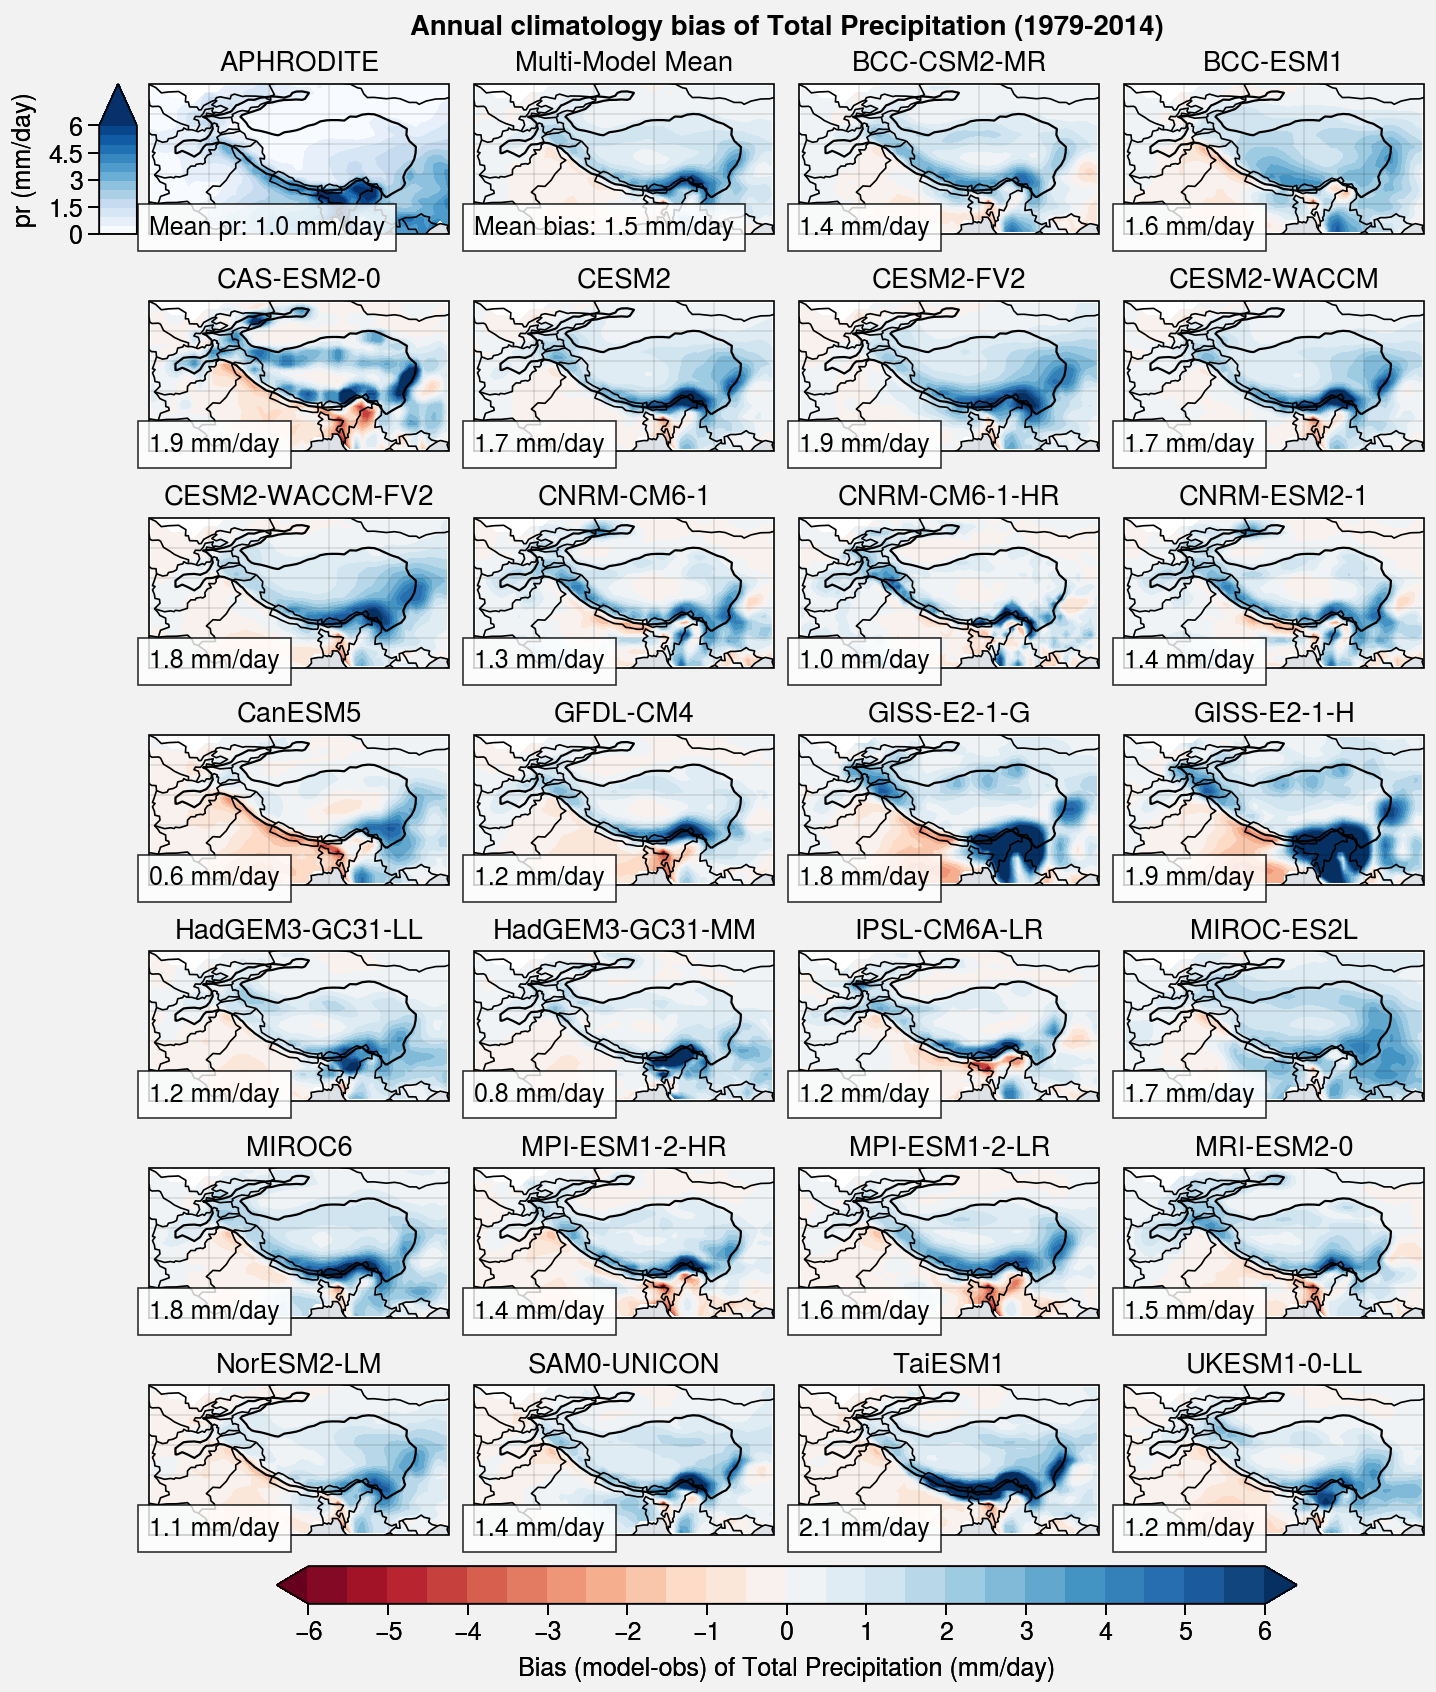

In [9]:
facecolor = 'white'
alpha = 0.8

# for season in seasons:
for season in ['Annual']:
    f, axs = plot.subplots(proj='cyl', ncols=4, nrows=7, axwidth=1.5)
    
    # Plot observation
    ax = axs[0]
    ax.contourf(
        obs_clim_regrid.sel(season=season), cmap='Blues', 
        levels=plot.arange(0,6,0.5), colorbar='l', extend='max',
        colorbar_kw={'label': 'pr (mm/day)'}
    )
    ax.format(title=obs_name)
    ax.text(
        60, 20, 
        'Mean '+var+': '+str(np.round(u.spatial_average(obs_clim_regrid.sel(season=season, lat=latlim, lon=lonlim).where(elevation > 2500)).values, 1))+' '+units,
        bbox=dict(facecolor=facecolor, alpha=alpha)
    )
    
    
    levels = plot.arange(-6,6,0.5)
    extend = 'both'
    cmap = 'RdBu'
    
    # Multimodel mean
    ax = axs[1]
    m = ax.contourf(
        multimodel_ensemble_bias_mmm.sel(season=season)[-1], cmap=cmap, 
        levels=levels, extend=extend
    ),
    ax.format(title=str(multimodel_ensemble_bias_mmm.sel(season=season).model[-1].values),)
    ax.text(
        60, 20, 
        'Mean bias: '+str(np.round(u.spatial_average(multimodel_ensemble_bias_mmm.sel(season=season)[-1].where(elevation > 2500)).values, 1))+' '+units,
        bbox=dict(facecolor=facecolor, alpha=alpha)
    )
    
    for i, ax in enumerate(axs[2:]):
        m = ax.contourf(
            multimodel_ensemble_bias_mmm.sel(season=season)[i], cmap=cmap, 
            levels=levels, extend=extend
        ),
        ax.format(title=str(multimodel_ensemble_bias_mmm.sel(season=season).model[i].values))
        ax.text(
            60, 20, 
            str(np.round(u.spatial_average(multimodel_ensemble_bias_mmm.sel(season=season)[i].where(elevation > 2500)).values, 1))+' '+units,
            bbox=dict(facecolor=facecolor, alpha=alpha)
        )
    
    # Contour HMA > 2500 m
    for ax in axs:
        ax.contour(elevation, levels=[2500], color='black', linewidth=0.8)

    # Colobar
    f.colorbar(m, label='Bias (model-obs) of '+label+' ('+units+')', loc='b', length=0.8, extend='both')

    axs.format(
        labels=False, lonlines=10, latlines=5, 
        latlim=(latlim.start, latlim.stop), lonlim=(lonlim.start, lonlim.stop),
        coast=True, ocean=True, oceancolor='gray3', borders=True,
        suptitle=season+' climatology bias of '+label+' ('+period.start+'-'+period.stop+')',
        abc=False
    )
    
    filename = 'fig2_'+season+'_clim_bias_'+var+'_'+period.start+'-'+period.stop
#     f.save('img/'+filename+'.jpg'); f.save('img/'+filename+'.png'); f.save('img/'+filename+'.pdf')

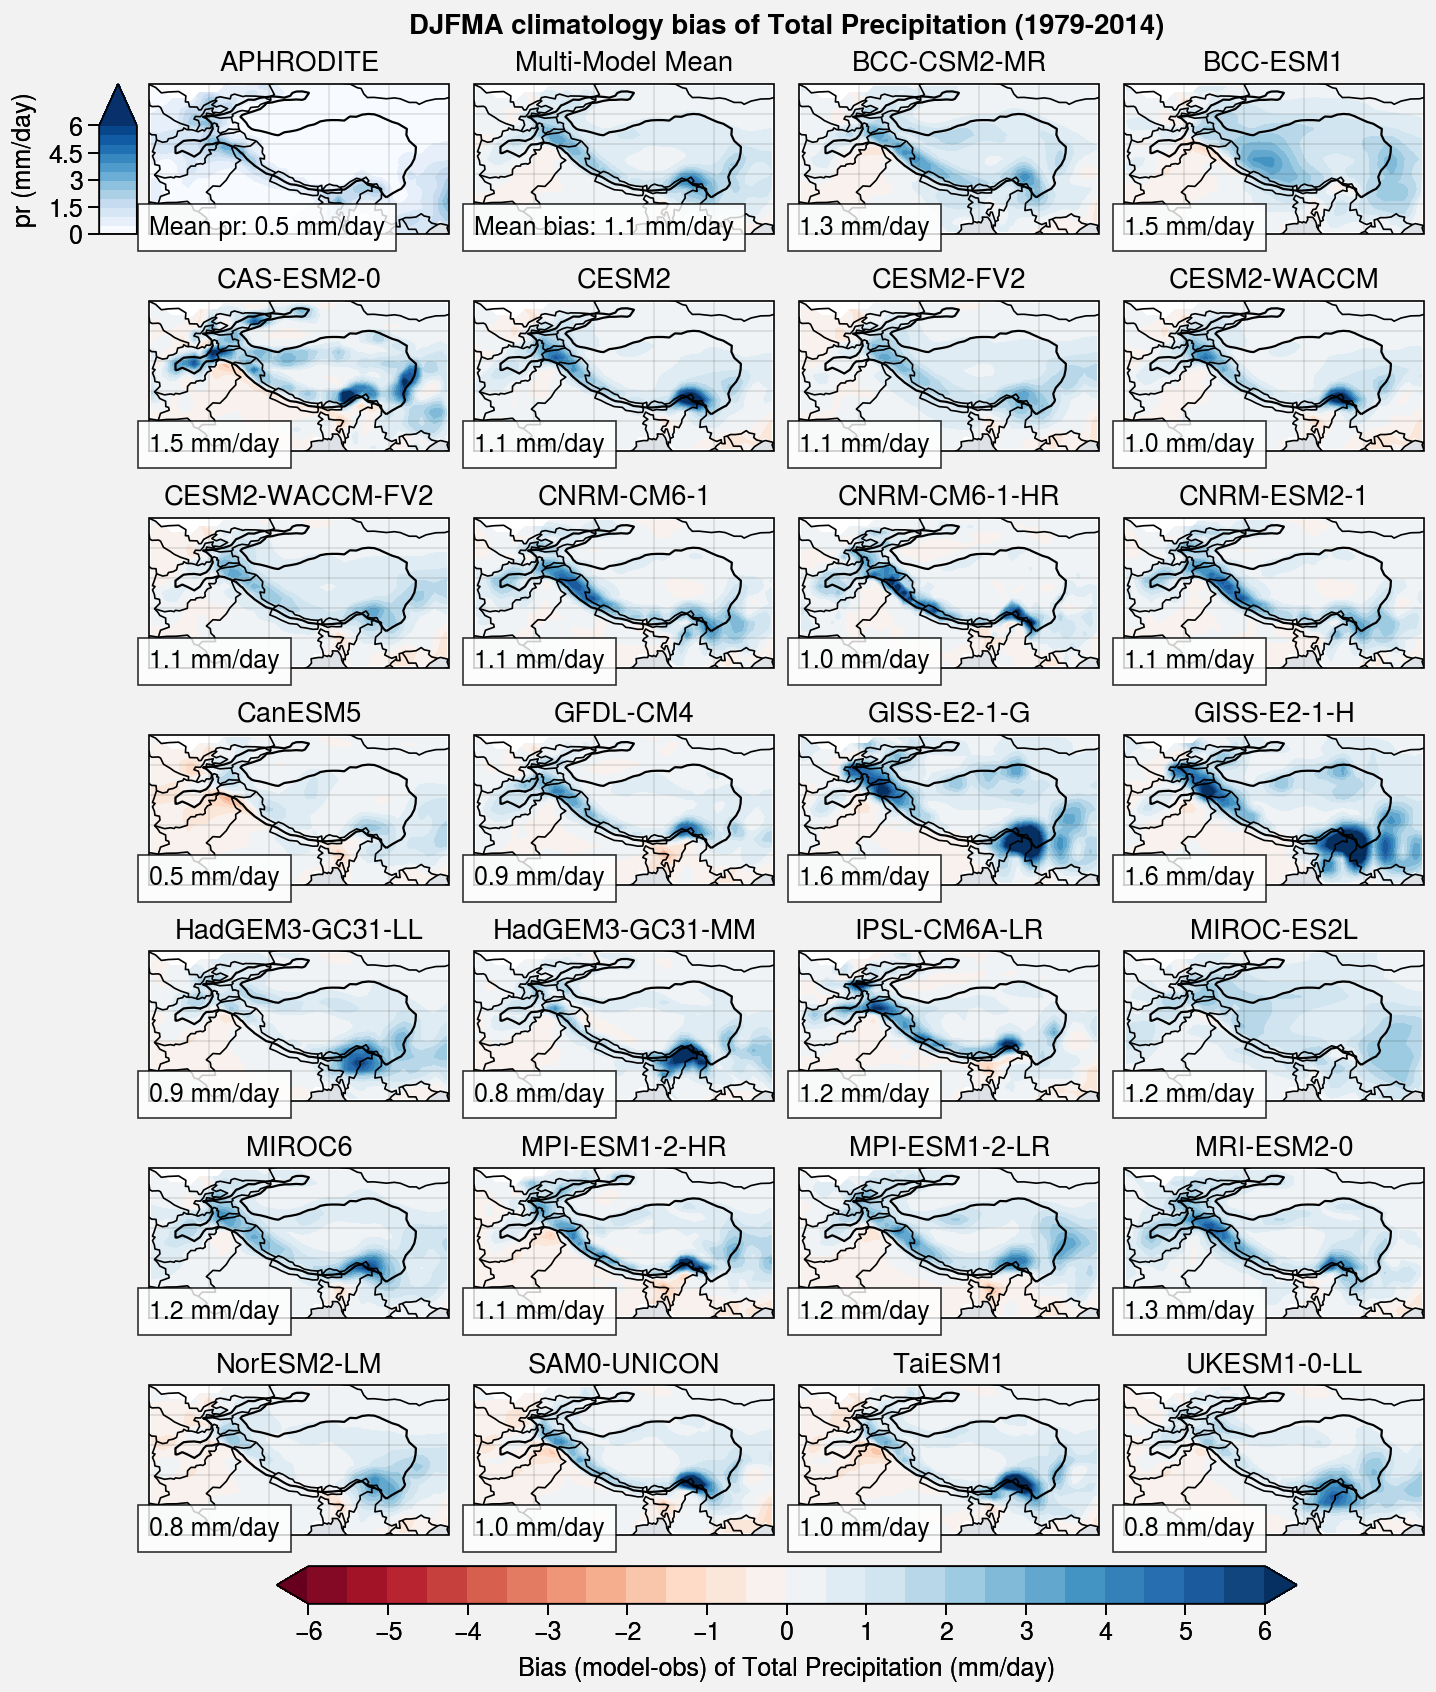

In [10]:
facecolor = 'white'
alpha = 0.8

# for season in seasons:
for season in ['DJFMA']:
    f, axs = plot.subplots(proj='cyl', ncols=4, nrows=7, axwidth=1.5)
    
    # Plot observation
    ax = axs[0]
    ax.contourf(
        obs_clim_regrid.sel(season=season), cmap='Blues', 
        levels=plot.arange(0,6,0.5), colorbar='l', extend='max',
        colorbar_kw={'label': 'pr (mm/day)'}
    )
    ax.format(title=obs_name)
    ax.text(
        60, 20, 
        'Mean '+var+': '+str(np.round(u.spatial_average(obs_clim_regrid.sel(season=season, lat=latlim, lon=lonlim).where(elevation > 2500)).values, 1))+' '+units,
        bbox=dict(facecolor=facecolor, alpha=alpha)
    )
    
    
    levels = plot.arange(-6,6,0.5)
    extend = 'both'
    cmap = 'RdBu'
    
    # Multimodel mean
    ax = axs[1]
    m = ax.contourf(
        multimodel_ensemble_bias_mmm.sel(season=season)[-1], cmap=cmap, 
        levels=levels, extend=extend
    ),
    ax.format(title=str(multimodel_ensemble_bias_mmm.sel(season=season).model[-1].values),)
    ax.text(
        60, 20, 
        'Mean bias: '+str(np.round(u.spatial_average(multimodel_ensemble_bias_mmm.sel(season=season)[-1].where(elevation > 2500)).values, 1))+' '+units,
        bbox=dict(facecolor=facecolor, alpha=alpha)
    )
    
    for i, ax in enumerate(axs[2:]):
        m = ax.contourf(
            multimodel_ensemble_bias_mmm.sel(season=season)[i], cmap=cmap, 
            levels=levels, extend=extend
        ),
        ax.format(title=str(multimodel_ensemble_bias_mmm.sel(season=season).model[i].values))
        ax.text(
            60, 20, 
            str(np.round(u.spatial_average(multimodel_ensemble_bias_mmm.sel(season=season)[i].where(elevation > 2500)).values, 1))+' '+units,
            bbox=dict(facecolor=facecolor, alpha=alpha)
        )
    
    # Contour HMA > 2500 m
    for ax in axs:
        ax.contour(elevation, levels=[2500], color='black', linewidth=0.8)

    # Colobar
    f.colorbar(m, label='Bias (model-obs) of '+label+' ('+units+')', loc='b', length=0.8, extend='both')

    axs.format(
        labels=False, lonlines=10, latlines=5, 
        latlim=(latlim.start, latlim.stop), lonlim=(lonlim.start, lonlim.stop),
        coast=True, ocean=True, oceancolor='gray3', borders=True,
        suptitle=season+' climatology bias of '+label+' ('+period.start+'-'+period.stop+')',
        abc=False
    )
    
    filename = 'fig2_'+season+'_clim_bias_'+var+'_'+period.start+'-'+period.stop
    f.save('img/'+filename+'.jpg'); f.save('img/'+filename+'.png'); f.save('img/'+filename+'.pdf')

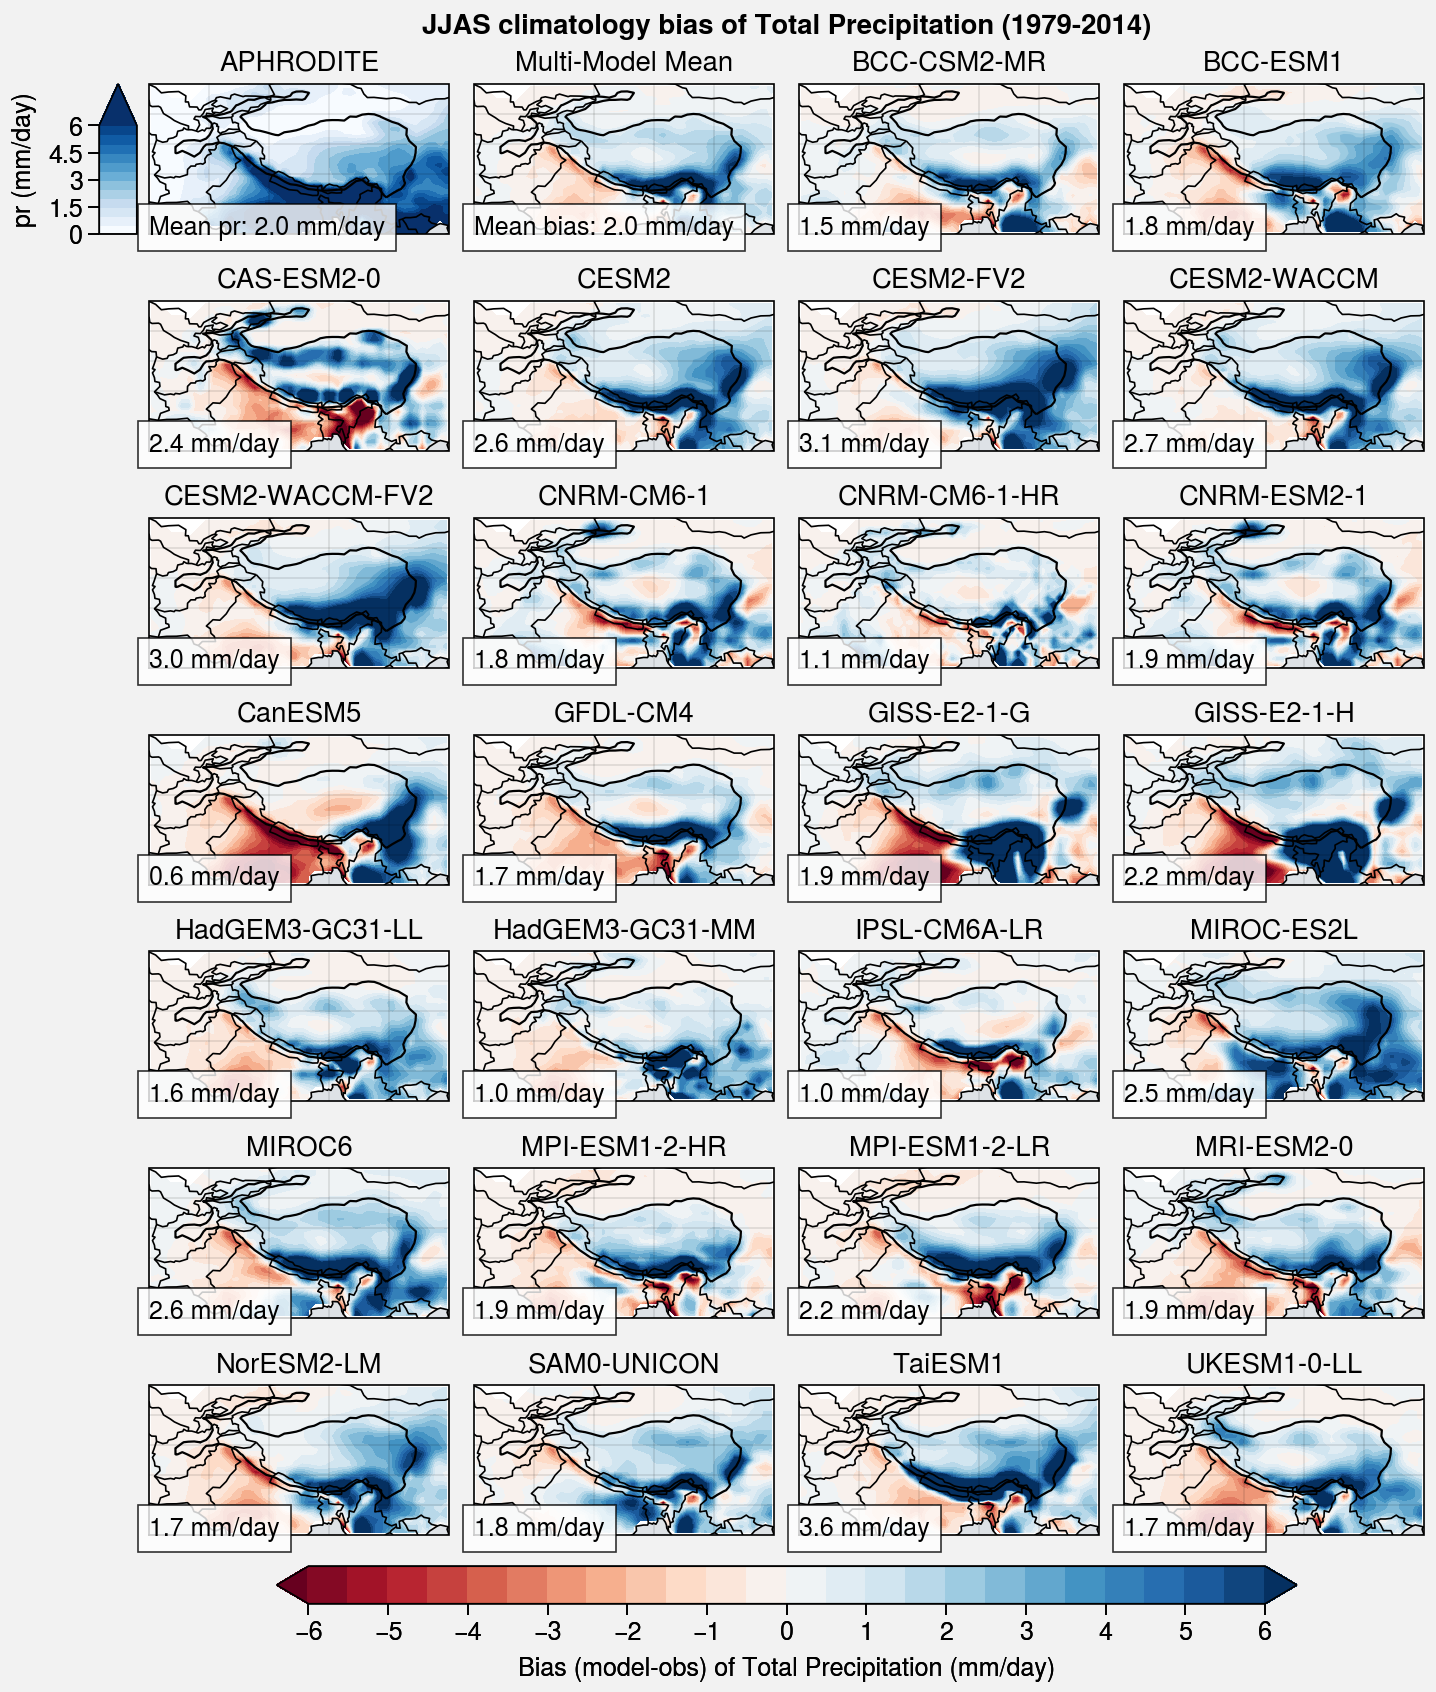

In [11]:
facecolor = 'white'
alpha = 0.8

# for season in seasons:
for season in ['JJAS']:
    f, axs = plot.subplots(proj='cyl', ncols=4, nrows=7, axwidth=1.5)
    
    # Plot observation
    ax = axs[0]
    ax.contourf(
        obs_clim_regrid.sel(season=season), cmap='Blues', 
        levels=plot.arange(0,6,0.5), colorbar='l', extend='max',
        colorbar_kw={'label': 'pr (mm/day)'}
    )
    ax.format(title=obs_name)
    ax.text(
        60, 20, 
        'Mean '+var+': '+str(np.round(u.spatial_average(obs_clim_regrid.sel(season=season, lat=latlim, lon=lonlim).where(elevation > 2500)).values, 1))+' '+units,
        bbox=dict(facecolor=facecolor, alpha=alpha)
    )
    
    
    levels = plot.arange(-6,6,0.5)
    extend = 'both'
    cmap = 'RdBu'
    
    # Multimodel mean
    ax = axs[1]
    m = ax.contourf(
        multimodel_ensemble_bias_mmm.sel(season=season)[-1], cmap=cmap, 
        levels=levels, extend=extend
    ),
    ax.format(title=str(multimodel_ensemble_bias_mmm.sel(season=season).model[-1].values),)
    ax.text(
        60, 20, 
        'Mean bias: '+str(np.round(u.spatial_average(multimodel_ensemble_bias_mmm.sel(season=season)[-1].where(elevation > 2500)).values, 1))+' '+units,
        bbox=dict(facecolor=facecolor, alpha=alpha)
    )
    
    for i, ax in enumerate(axs[2:]):
        m = ax.contourf(
            multimodel_ensemble_bias_mmm.sel(season=season)[i], cmap=cmap, 
            levels=levels, extend=extend
        ),
        ax.format(title=str(multimodel_ensemble_bias_mmm.sel(season=season).model[i].values))
        ax.text(
            60, 20, 
            str(np.round(u.spatial_average(multimodel_ensemble_bias_mmm.sel(season=season)[i].where(elevation > 2500)).values, 1))+' '+units,
            bbox=dict(facecolor=facecolor, alpha=alpha)
        )
    
    # Contour HMA > 2500 m
    for ax in axs:
        ax.contour(elevation, levels=[2500], color='black', linewidth=0.8)

    # Colobar
    f.colorbar(m, label='Bias (model-obs) of '+label+' ('+units+')', loc='b', length=0.8, extend='both')

    axs.format(
        labels=False, lonlines=10, latlines=5, 
        latlim=(latlim.start, latlim.stop), lonlim=(lonlim.start, lonlim.stop),
        coast=True, ocean=True, oceancolor='gray3', borders=True,
        suptitle=season+' climatology bias of '+label+' ('+period.start+'-'+period.stop+')',
        abc=False
    )
    
    filename = 'fig2_'+season+'_clim_bias_'+var+'_'+period.start+'-'+period.stop
    f.save('img/'+filename+'.jpg'); f.save('img/'+filename+'.png'); f.save('img/'+filename+'.pdf')